In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
import seaborn as sb
import mne
from pyriemann.estimation import Covariances
from pyriemann.tangentspace import TangentSpace
# from pyriemann.classification import TSclassifier, MDM, FgMDM
from pyriemann.utils.distance import distance_riemann, distance_euclid, distance_logeuclid
from pyriemann.utils.mean import mean_riemann, mean_euclid, mean_logeuclid
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
import pickle as pkl
from braindecode.datasets import BaseConcatDataset
from data_util import euclidean_alignment, label_alignment
from copy import deepcopy
import json
import re

In [38]:
with open("../data/beetl/PHY_LRF0_001_040_4-38Hz_BRD.pkl", mode="rb") as f:
    ds = pkl.load(f)
    
ds_info = ds.description
ds_info

,subject,scenario,event,label,label_idx,trial,split
0,PHY_001,rest,Resting,rest,0,0,train
1,PHY_001,right_hand,Thinking,right_hand,2,0,train
2,PHY_001,rest,Resting,rest,0,0,train
3,PHY_001,left_hand,Thinking,left_hand,3,0,train
4,PHY_001,rest,Resting,rest,0,0,train
...,...,...,...,...,...,...,...
6293,PHY_040,rest,Resting,rest,0,5,train
6294,PHY_040,feet,Thinking,feet,1,5,train
6295,PHY_040,rest,Resting,rest,0,5,train
6296,PHY_040,rest,Resting,rest,0,5,train


In [39]:
ds_info.groupby(["label", "label_idx"]).count()

,,subject,scenario,event,trial,split
label,label_idx,,,,,
feet,1,898,898,898,898,898
left_hand,3,905,905,905,905,905
rest,0,3600,3600,3600,3600,3600
right_hand,2,895,895,895,895,895


In [53]:
X = list()
Y = list()
S = list()
for sub in range(1, 11):
    for i in ds_info[ds_info["subject"] == f"PHY_{sub:03d}"].index:
        X.append(ds.datasets[i].windows.get_data())
        Y.extend(ds.datasets[i].y)
        S.extend([f"S{sub:03d}"] * len(ds.datasets[i].y))
        
X = np.concatenate(X, axis=0)
Y = np.array(Y, dtype=int)

le = LabelEncoder()
S = le.fit_transform(S)

X.shape, Y.shape, S.shape

((1576, 64, 384), (1576,), (1576,))

In [54]:
C = Covariances().fit_transform(X)
# C = np.stack([np.cov(x, rowvar=True) for x in X])
C.shape

(1576, 64, 64)

In [55]:
# feat = list()
# for s in np.unique(S):
#     ts = TangentSpace(metric="riemann")
#     subfeat = ts.fit_transform(C[np.where(S == s)[0]])
#     feat.append(subfeat)

# feat = np.concatenate(feat, axis=0)
# feat.shape

ts = TangentSpace(metric="riemann")
feat = ts.fit_transform(C)
feat.shape

(1576, 2080)

In [56]:
tsne = TSNE(n_components=2, init="random")
feat2d = tsne.fit_transform(feat)
feat2d.shape

/home/txdat/.miniconda3/envs/eeg/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


(1576, 2)

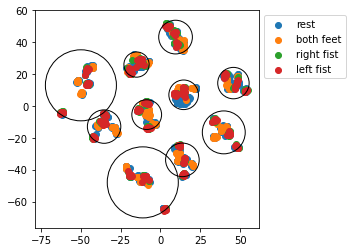

In [58]:
fig = plt.figure()

ax = plt.gca()
ax.cla()
ax.set_aspect('equal')

for y in np.unique(Y):
    idx = np.where(Y == y)[0]
    plt.scatter(feat2d[idx, 0], feat2d[idx, 1])
    
plt.legend(["rest", "both feet", "right fist", "left fist"], bbox_to_anchor=(1., 1.0))
# plt.legend(le.classes_, bbox_to_anchor=(1., 1.0))

for s in np.unique(S):
    idx = np.where(S == s)[0]
    pp = feat2d[idx]
    xy = pp.mean(axis=0)
    r = xy[None] - pp
    r **= 2
    r = np.sqrt(r[:, 0] + r[:, 1]).max()
    ax.add_patch(plt.Circle((xy[0], xy[1]), radius=r, color='k', fill=False))

In [59]:
fig.savefig("physionet_riemann_before_ea.png")

In [60]:
ea_ds = list()
for sub in range(1, 11):
    for i in ds_info[ds_info["subject"] == f"PHY_{sub:03d}"].index:
        ea_ds.append(deepcopy(ds.datasets[i]))
        
ea_ds = BaseConcatDataset(ea_ds)
for _ds in ea_ds.datasets:
    _ds.windows.load_data()

euclidean_alignment(ea_ds, target_subject=None)

ea_ds_info = ea_ds.description

ea_ds_info

subject: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.36it/s]


,subject,scenario,event,label,label_idx,trial,split
0,PHY_001,rest,Resting,rest,0,0,train
1,PHY_001,right_hand,Thinking,right_hand,2,0,train
2,PHY_001,rest,Resting,rest,0,0,train
3,PHY_001,left_hand,Thinking,left_hand,3,0,train
4,PHY_001,rest,Resting,rest,0,0,train
...,...,...,...,...,...,...,...
1571,PHY_010,rest,Resting,rest,0,5,train
1572,PHY_010,rest,Resting,rest,0,5,train
1573,PHY_010,feet,Thinking,feet,1,5,train
1574,PHY_010,rest,Resting,rest,0,5,train


In [61]:
X = list()
Y = list()
S = list()
for sub in range(1, 11):
    for i in ea_ds_info[ea_ds_info["subject"] == f"PHY_{sub:03d}"].index:
        X.append(ea_ds.datasets[i].windows.get_data())
        Y.extend(ea_ds.datasets[i].y)
        S.extend([f"S{sub:03d}"] * len(ea_ds.datasets[i].y))
        
X = np.concatenate(X, axis=0)
Y = np.array(Y, dtype=int)

le = LabelEncoder()
S = le.fit_transform(S)

X.shape, Y.shape, S.shape

((1576, 64, 384), (1576,), (1576,))

In [62]:
C = Covariances().fit_transform(X)
C.shape

(1576, 64, 64)

In [63]:
# feat = list()
# for s in np.unique(S):
#     ts = TangentSpace(metric="riemann")
#     subfeat = ts.fit_transform(C[np.where(S == s)[0]])
#     feat.append(subfeat)

# feat = np.concatenate(feat, axis=0)
# feat.shape

ts = TangentSpace(metric="riemann")
feat = ts.fit_transform(C)
feat.shape

(1576, 2080)

In [64]:
tsne = TSNE(n_components=2, init="pca")
feat2d = tsne.fit_transform(feat)
feat2d.shape

/home/txdat/.miniconda3/envs/eeg/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/home/txdat/.miniconda3/envs/eeg/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


(1576, 2)

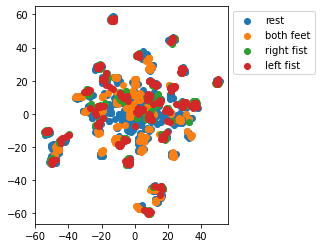

In [65]:
fig = plt.figure()

ax = plt.gca()
ax.cla()
ax.set_aspect('equal')

for y in np.unique(Y):
    idx = np.where(Y == y)[0]
    plt.scatter(feat2d[idx, 0], feat2d[idx, 1])
    
plt.legend(["rest", "both feet", "right fist", "left fist"], bbox_to_anchor=(1., 1.0))
# plt.legend(le.classes_, bbox_to_anchor=(1., 1.0))

# for s in np.unique(S):
#     idx = np.where(S == s)[0]
#     pp = feat2d[idx]
#     xy = pp.mean(axis=0)
#     r = xy[None] - pp
#     r **= 2
#     r = np.sqrt(r[:, 0] + r[:, 1]).max()
#     ax.add_patch(plt.Circle((xy[0], xy[1]), radius=r, color='k', fill=False))

In [66]:
fig.savefig("physionet_riemann_after_ea.png")

In [82]:
la_ds = list()
for sub in range(1, 11):
    for i in ds_info[ds_info["subject"] == f"PHY_{sub:03d}"].index:
        la_ds.append(deepcopy(ds.datasets[i]))
        
la_ds = BaseConcatDataset(la_ds)
for _ds in la_ds.datasets:
    _ds.windows.load_data()

label_alignment(la_ds, target_subject="PHY_001", metric="logeuclid")

la_ds_info = la_ds.description

la_ds_info

subject: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.12it/s]


,subject,scenario,event,label,label_idx,trial,split
0,PHY_001,rest,Resting,rest,0,0,train
1,PHY_001,right_hand,Thinking,right_hand,2,0,train
2,PHY_001,rest,Resting,rest,0,0,train
3,PHY_001,left_hand,Thinking,left_hand,3,0,train
4,PHY_001,rest,Resting,rest,0,0,train
...,...,...,...,...,...,...,...
1571,PHY_010,rest,Resting,rest,0,5,train
1572,PHY_010,rest,Resting,rest,0,5,train
1573,PHY_010,feet,Thinking,feet,1,5,train
1574,PHY_010,rest,Resting,rest,0,5,train


In [83]:
X = list()
Y = list()
S = list()
for sub in range(1, 11):
    for i in la_ds_info[la_ds_info["subject"] == f"PHY_{sub:03d}"].index:
        X.append(la_ds.datasets[i].windows.get_data())
        Y.extend(la_ds.datasets[i].y)
        S.extend([f"PHY_{sub:03d}"] * len(la_ds.datasets[i].y))
        
X = np.concatenate(X, axis=0)
Y = np.array(Y, dtype=int)

le = LabelEncoder()
S = le.fit_transform(S)

X.shape, Y.shape, S.shape

((1576, 64, 384), (1576,), (1576,))

In [84]:
C = Covariances().fit_transform(X)
C.shape

(1576, 64, 64)

In [85]:
ts = TangentSpace(metric="riemann")
feat = ts.fit_transform(C)
feat.shape

(1576, 2080)

In [86]:
tsne = TSNE(n_components=2)
feat2d = tsne.fit_transform(feat)
feat2d.shape

/home/txdat/.miniconda3/envs/eeg/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/txdat/.miniconda3/envs/eeg/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


(1576, 2)

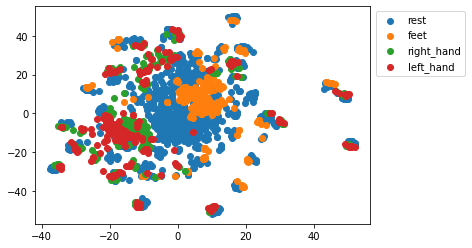

In [96]:
for y in np.unique(Y):
    idx = np.where(Y == y)[0]
    plt.scatter(feat2d[idx, 0], feat2d[idx, 1])
    
plt.legend(["rest", "feet", "right_hand", "left_hand"], bbox_to_anchor=(1.3, 1.0))

In [7]:
import pandas as pd
import json
import re

subpatt = re.compile("(K|ALS)\d{2,3}(_t\d+)?")

In [281]:
res = list()

# sub = None
# with open("../vin/EEG_results/EEG_K_LRF0_final.txt", mode="r", encoding="utf-8") as f:
#     for line in f:
#         line = line.strip()
#         if line.startswith("testing on"):
#             sub = subpatt.search(line).group()
#         elif line.startswith("{'acc'") and sub is not None:
#             subres = json.loads(line.replace("'", "\""))
#             subres["subject"] = sub
#             sub = None
#             res.append(subres)
            
sub = None
with open("../vin/EEG_results_final_2/EEG_K_LR0.txt", mode="r", encoding="utf-8") as f:
    for line in f:
        line = line.strip()
        if line.startswith("testing on"):
            sub = subpatt.search(line).group()
        elif line.startswith("{'acc'") and sub is not None:
            subres = json.loads(line.replace("'", "\""))
            subres["subject"] = sub
            sub = None
            res.append(subres)

In [282]:
res = pd.DataFrame(res)
print(len(res))
res[30:].mean()

60


/home/txdat/.miniconda3/envs/eeg/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  This is separate from the ipykernel package so we can avoid doing imports until


acc      0.694169
f1       0.736662
kappa    0.576054
dtype: float64

In [63]:
res = res.loc[res.groupby("subject")["acc"].idxmax()][["subject", "acc", "f1", "kappa"]].reset_index(drop=True)
res = res.rename(columns={"acc": "Balanced accuracy", "f1": "F1 score", "kappa": "Cohen's kappa"})
res

,subject,Balanced accuracy,F1 score,Cohen's kappa
0,K309,0.554226,0.491775,0.249156
1,K311,0.675312,0.740731,0.525609
2,K312,0.363923,0.484405,0.148890
3,K313,0.594455,0.541953,0.316255
4,K315,0.808942,0.877702,0.761950
5,K316,0.594264,0.749575,0.538592
6,K321,0.535714,0.423546,0.214765
7,K322,0.742690,0.786143,0.658199
8,K323,0.641576,0.648400,0.515778
9,K325,0.632212,0.586280,0.467419


In [64]:
res.mean()

/home/txdat/.miniconda3/envs/eeg/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


Balanced accuracy    0.643961
F1 score             0.666805
Cohen's kappa        0.494197
dtype: float64

In [40]:
res = list()
subject = None
with open("../vin/EEG_results/EEG_K_EA_SVM_LRF0.txt", mode="r", encoding="utf-8") as f:
    for line in f:
        line = line.strip()
        if line.startswith("subject"):
            # print(line)
            subject = line.split()[-1]
        elif line.startswith("n_components"):
            _, acc, f1, kappa = [x.strip() for x in line.split("-")]
            acc = float(acc.split()[-1])
            f1 = float(f1.split()[-1])
            kappa = float(kappa.split()[-1])
            res.append((subject, acc, f1, kappa))
            
res = pd.DataFrame(res, columns=["subject", "acc", "f1", "kappa"])
res.mean()

/home/txdat/.miniconda3/envs/eeg/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  app.launch_new_instance()


acc      0.625338
f1       0.705636
kappa    0.568795
dtype: float64

In [152]:
res = [
    ("[EA]-EEGITNet", True, 0.620366, 0.707653, 0.547940),
    ("[EA]-CSP-BP-SVM", True, 0.755744, 0.786804, 0.657233),
    ("CSP-BP-SVM", False, 0.693820, 0.732977, 0.588193),
]

res = pd.DataFrame(res, columns=["Method", "EA", "Balanced accuracy", "F1 score", "Cohen's kappa"])
res

,Method,EA,Balanced accuracy,F1 score,Cohen's kappa
0,[EA]-EEGITNet,True,0.620366,0.707653,0.547940
1,[EA]-CSP-BP-SVM,True,0.625338,0.705636,0.568795
2,CSP-BP-SVM,False,0.551747,0.672468,0.505351


[]

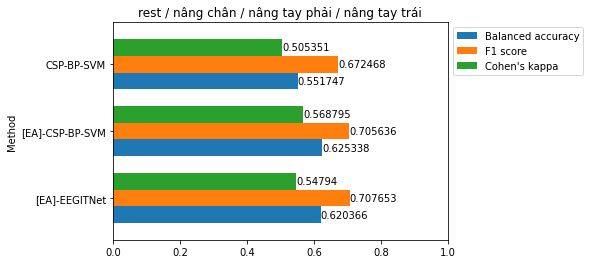

In [153]:
ax = res.set_index("Method").plot.barh(y=["Balanced accuracy", "F1 score", "Cohen's kappa"], width=0.75)
ax.set_title("rest / nâng chân / nâng tay phải / nâng tay trái",color='black')
ax.legend(bbox_to_anchor=(1.0, 1.0))
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
ax.bar_label(ax.containers[2])
ax.set_xlim((0, 1))
ax.plot()

In [207]:
res = list()

for als in ["ALS01", "ALS02", "ALS04", "ALS05"]:
    subject = None
    metrics = None
    with open(f"../vin/EEG_results/{als}_LRF0_K_final2.txt", mode="r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if line.startswith("testing on"):
                subject = subpatt.search(line).group()
            elif line.startswith("{'acc'"):
                if subject is not None:
                    metrics = json.loads(line.replace("'", "\""))
                    metrics["subject"] = subject
                    res.append(metrics)
                    subject = None


    subject = None
    metrics = None
    with open(f"../vin/EEG_results/{als}_LRF0_K_final3.txt", mode="r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if line.startswith("testing on"):
                subject = subpatt.search(line).group()
            elif line.startswith("{'acc'"):
                if subject is not None:
                    metrics = json.loads(line.replace("'", "\""))
                    metrics["subject"] = subject
                    res.append(metrics)
                    subject = None
                
res = pd.DataFrame(res)
res

,acc,f1,kappa,subject
0,0.565273,0.679301,0.579017,ALS01_t1
1,0.453540,0.595760,0.372136,ALS01_t2
2,0.497476,0.591727,0.442133,ALS01_t3
3,0.478906,0.556766,0.380748,ALS01_t4
4,0.585528,0.660802,0.561603,ALS01_t5
...,...,...,...,...
78,0.371012,0.523210,0.232018,ALS05_t2
79,0.433885,0.490581,0.304525,ALS05_t3
80,0.446747,0.453634,0.260682,ALS05_t4
81,0.398083,0.429900,0.185891,ALS05_t5


In [208]:
res = res.loc[res.groupby("subject")["acc"].idxmax()][["subject", "acc", "f1", "kappa"]].reset_index(drop=True)
res = res.rename(columns={"acc": "Balanced accuracy", "f1": "F1 score", "kappa": "Cohen's kappa"})
res

,subject,Balanced accuracy,F1 score,Cohen's kappa
0,ALS01_t1,0.565273,0.679301,0.579017
1,ALS01_t10,0.604148,0.547350,0.332592
2,ALS01_t2,0.453540,0.595760,0.372136
3,ALS01_t3,0.509138,0.600817,0.460467
4,ALS01_t4,0.478906,0.556766,0.380748
5,ALS01_t5,0.608855,0.680448,0.597618
6,ALS01_t6,0.772589,0.784017,0.713896
7,ALS01_t7,0.617671,0.645479,0.529412
8,ALS01_t8,0.619987,0.642402,0.512002
9,ALS01_t9,0.541656,0.573207,0.464372


In [209]:
res["subject"] = res["subject"].apply(lambda x: x.split("_")[0])
res

,subject,Balanced accuracy,F1 score,Cohen's kappa
0,ALS01,0.565273,0.679301,0.579017
1,ALS01,0.604148,0.547350,0.332592
2,ALS01,0.453540,0.595760,0.372136
3,ALS01,0.509138,0.600817,0.460467
4,ALS01,0.478906,0.556766,0.380748
5,ALS01,0.608855,0.680448,0.597618
6,ALS01,0.772589,0.784017,0.713896
7,ALS01,0.617671,0.645479,0.529412
8,ALS01,0.619987,0.642402,0.512002
9,ALS01,0.541656,0.573207,0.464372


In [210]:
res.groupby("subject").mean()

,Balanced accuracy,F1 score,Cohen's kappa
subject,,,
ALS01,0.577176,0.630555,0.494226
ALS02,0.563544,0.544212,0.391021
ALS04,0.501610,0.524246,0.373458
ALS05,0.461435,0.544754,0.330253


[]

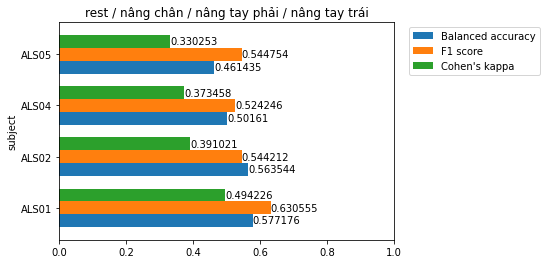

In [214]:
ax = res.groupby("subject").mean().plot.barh(y=["Balanced accuracy", "F1 score", "Cohen's kappa"], width=0.75)
ax.set_title("rest / nâng chân / nâng tay phải / nâng tay trái",color='black')
ax.legend(bbox_to_anchor=(1.45, 1.0))
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
ax.bar_label(ax.containers[2])
ax.set_xlim((0, 1))
ax.plot()

In [189]:
res = list()

sub = None
with open("../vin/EEG_results/EEG_K_ALS_LRF0.txt", mode="r", encoding="utf-8") as f:
    for line in f:
        line = line.strip()
        if line.startswith("testing on"):
            sub = subpatt.search(line).group()
        elif line.startswith("{'acc'") and sub is not None:
            subres = json.loads(line.replace("'", "\""))
            subres["subject"] = sub
            sub = None
            res.append(subres)

In [190]:
res = pd.DataFrame(res)
res

,acc,f1,kappa,subject
0,0.344356,0.437697,0.213519,ALS01_t1
1,0.424845,0.335739,0.125376,ALS01_t10
2,0.340634,0.298423,0.113244,ALS01_t2
3,0.455316,0.483193,0.295633,ALS01_t3
4,0.302361,0.329972,0.096220,ALS01_t4
...,...,...,...,...
139,0.386479,0.355907,0.165894,ALS04_t4
140,0.386445,0.384462,0.200511,ALS04_t5
141,0.298772,0.239578,0.065109,ALS04_t6
142,0.435595,0.449112,0.265092,ALS04_t7


In [191]:
res = res.loc[res.groupby("subject")["acc"].idxmax()][["subject", "acc", "f1", "kappa"]].reset_index(drop=True)
res = res.rename(columns={"acc": "Balanced accuracy", "f1": "F1 score", "kappa": "Cohen's kappa"})
res

,subject,Balanced accuracy,F1 score,Cohen's kappa
0,ALS01_t1,0.365784,0.462255,0.251571
1,ALS01_t10,0.440090,0.304129,0.099547
2,ALS01_t2,0.370962,0.326207,0.139242
3,ALS01_t3,0.522049,0.540251,0.377018
4,ALS01_t4,0.363501,0.385162,0.166647
5,ALS01_t5,0.472450,0.468468,0.300315
6,ALS01_t6,0.554542,0.559282,0.403574
7,ALS01_t7,0.382087,0.348955,0.164353
8,ALS01_t8,0.447753,0.482527,0.274666
9,ALS01_t9,0.697160,0.680521,0.565931


In [192]:
res["subject"] = res["subject"].apply(lambda x: x.split("_")[0])
res

,subject,Balanced accuracy,F1 score,Cohen's kappa
0,ALS01,0.365784,0.462255,0.251571
1,ALS01,0.440090,0.304129,0.099547
2,ALS01,0.370962,0.326207,0.139242
3,ALS01,0.522049,0.540251,0.377018
4,ALS01,0.363501,0.385162,0.166647
5,ALS01,0.472450,0.468468,0.300315
6,ALS01,0.554542,0.559282,0.403574
7,ALS01,0.382087,0.348955,0.164353
8,ALS01,0.447753,0.482527,0.274666
9,ALS01,0.697160,0.680521,0.565931


[]

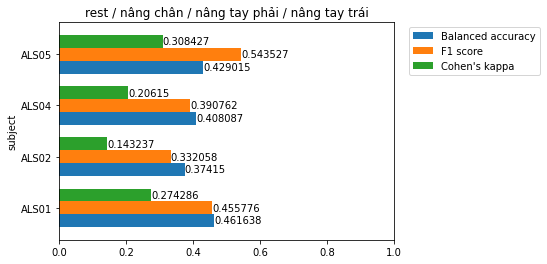

In [198]:
ax = res.groupby("subject").mean().plot.barh(y=["Balanced accuracy", "F1 score", "Cohen's kappa"], width=0.75)
ax.set_title("rest / nâng chân / nâng tay phải / nâng tay trái",color='black')
ax.legend(bbox_to_anchor=(1.45, 1.0))
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
ax.bar_label(ax.containers[2])
ax.set_xlim((0, 1))
ax.plot()

In [18]:
res = list()

subpatt = re.compile("(PHY_|K)\d{3,}")

sub = None
list_of_cfm = list()
cfm = list()
with open("../vin/EEG_results_final_3/PHY_LR0_4-38Hz.txt", mode="r", encoding="utf-8") as f:
# with open("../vin/EEG_results_final_2/PHY_LR0_4-38Hz.txt", mode="r", encoding="utf-8") as f:
# with open("../data/beetl/LRF0_noEA.txt", mode="r", encoding="utf-8") as f:
    for line in f:
        line = line.strip()
        if line.startswith("testing on"):
            sub = subpatt.search(line).group()
        elif line.startswith("{'acc'") and sub is not None:
            subres = json.loads(line.replace("'", "\""))
            subres["subject"] = sub
            res.append(subres)
            sub = None
        elif line.startswith("["):
            if len(cfm) == 3:
                list_of_cfm.append(np.array(cfm, dtype=np.float32))
                cfm = list()
            line = line.replace("[", "").replace("]", "")
            x = [float(xi.strip()) for xi in line.split()]
            cfm.append(x)
            
res = pd.DataFrame(res)
            
list_of_cfm.append(np.array(cfm, dtype=np.float32))
list_of_cfm = np.stack(list_of_cfm)

len(list_of_cfm)

110

In [19]:
res

,acc,f1,kappa,subject
0,0.824887,0.816789,0.655646,PHY_001
1,0.833289,0.808623,0.644841,PHY_002
2,0.658147,0.715556,0.463767,PHY_003
3,0.734563,0.752519,0.535284,PHY_004
4,0.478704,0.592074,0.237945,PHY_005
...,...,...,...,...
100,0.805299,0.771300,0.582043,PHY_105
101,0.689153,0.726358,0.490806,PHY_106
102,0.535847,0.588550,0.265706,PHY_107
103,0.593822,0.696232,0.389071,PHY_108


In [20]:
set(range(0, len(list_of_cfm), 22))

{0, 22, 44, 66, 88}

In [21]:
list_of_cfm = np.stack([list_of_cfm[i] for i in range(len(list_of_cfm)) if i not in set(range(0, len(list_of_cfm), 22))])
len(list_of_cfm)

105

In [22]:
# acc      0.706442
# f1       0.749622
# kappa    0.594807

res.mean()

/home/txdat/.miniconda3/envs/eeg/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """


acc      0.700267
f1       0.723373
kappa    0.494968
dtype: float64

In [23]:
np.stack(list_of_cfm).mean(axis=0)

array([[0.7176657 , 0.1318514 , 0.15047812],
       [0.15561427, 0.685538  , 0.15886475],
       [0.15761995, 0.14479999, 0.69758743]], dtype=float32)

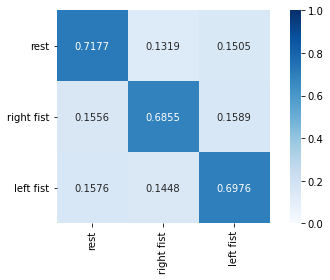

In [24]:
# lbl = ["rest", "nâng chân", "nâng tay phải", "nâng tay trái"]
lbl = ["rest", "right fist", "left fist"]
hm = sb.heatmap(np.stack(list_of_cfm).mean(axis=0), annot=True, fmt="0.4f", vmin=0, vmax=1, cmap="Blues", square=True, xticklabels=lbl, yticklabels=lbl)

plt.yticks(rotation=0)
plt.xticks(rotation=90)

plt.tight_layout()

In [25]:
hm.get_figure().savefig("physionet_lr0_cfm.png")

In [111]:
def confusion_matrix_figure(y_true, y_pred, n_classes) -> Figure:
    cfm = metrics.confusion_matrix(y_true, y_pred, labels=list(range(n_classes)), normalize="true")
    cfm = np.round(cfm, 4)

    fig = plt.figure()
    plt.imshow(cfm, cmap=plt.cm.Blues, vmin=0.0, vmax=1.0)
    for j in range(cfm.shape[1]):  # col: prediction
        for i in range(cfm.shape[0]):  # row: groundtruth
            plt.text(j, i, cfm[i, j], va="center", ha="center")

    return fig

In [37]:
res = pd.DataFrame(res)
res

,acc,f1,kappa,subject
0,0.735532,0.700068,0.546877,PHY_001
1,0.713845,0.649608,0.492860,PHY_002
2,0.598839,0.561107,0.378773,PHY_003
3,0.666491,0.660140,0.485342,PHY_004
4,0.387933,0.490211,0.214086,PHY_005
...,...,...,...,...
100,0.665821,0.524861,0.377682,PHY_105
101,0.446645,0.518901,0.274682,PHY_106
102,0.464562,0.490675,0.253391,PHY_107
103,0.527350,0.561433,0.336958,PHY_108


In [38]:
res.mean()

/home/txdat/.miniconda3/envs/eeg/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


acc      0.617452
f1       0.611880
kappa    0.429473
dtype: float64

In [3]:
import json
import glob
import os
import numpy as np
import pandas as pd

with open("../data/DataVIN/Official/K001/info.json", mode="r", encoding="utf-8") as f:
    d = json.load(f)
    
d

{'id': 'K001', 'name': 'Phùng Mạnh Phú', 'age': 45, 'gender': 'M'}

In [10]:
ages = list()
for sub in glob.glob("../data/DataVIN/ALS/als-patients/ALS*"):
    if not os.path.exists(f"{sub}/info.json"):
        continue
    with open(f"{sub}/info.json", mode="r", encoding="utf-8") as f:
        ages.append(json.load(f)["age"])

In [11]:
np.mean(ages)

48.15217391304348

In [264]:
subpatt = re.compile("ALS\d{2,}_t\d{1,2}")

res = list()
sub = None
list_of_cfm = list()
cfm = list()
with open("../vin/EEG_results_final_3/EEG_K&ALS_LRF0.txt", mode="r", encoding="utf-8") as f:
    for line in f:
        line = line.strip()
        if line.startswith("testing on"):
            sub = subpatt.search(line).group()
        elif line.startswith("{'acc'") and sub is not None:
            subres = json.loads(line.replace("'", "\""))
            subres["subject"] = sub
            res.append(subres)
            sub = None
        elif line.startswith("["):
            if len(cfm) == 4:
                list_of_cfm.append(np.array(cfm, dtype=np.float32))
                cfm = list()
            line = line.replace("[", "").replace("]", "")
            x = [float(xi.strip()) for xi in line.split()]
            cfm.append(x)
            
res = pd.DataFrame(res)
            
list_of_cfm.append(np.array(cfm, dtype=np.float32))
list_of_cfm = np.stack(list_of_cfm)

res

,acc,f1,kappa,subject
0,0.591401,0.683768,0.579482,ALS01_t1
1,0.487546,0.605094,0.387953,ALS01_t2
2,0.497858,0.575701,0.424693,ALS01_t3
3,0.474760,0.564028,0.386936,ALS01_t4
4,0.604395,0.673859,0.557287,ALS01_t5
5,0.770109,0.760976,0.683427,ALS01_t6
6,0.659326,0.665840,0.552630,ALS01_t7
7,0.547916,0.545455,0.400772,ALS01_t8
8,0.529260,0.560111,0.443522,ALS01_t9
9,0.671234,0.586476,0.401681,ALS01_t10


In [265]:
len(list_of_cfm)

68

In [266]:
res["subject"] = res["subject"].apply(lambda x: x.split("_")[0])
res

,acc,f1,kappa,subject
0,0.591401,0.683768,0.579482,ALS01
1,0.487546,0.605094,0.387953,ALS01
2,0.497858,0.575701,0.424693,ALS01
3,0.474760,0.564028,0.386936,ALS01
4,0.604395,0.673859,0.557287,ALS01
5,0.770109,0.760976,0.683427,ALS01
6,0.659326,0.665840,0.552630,ALS01
7,0.547916,0.545455,0.400772,ALS01
8,0.529260,0.560111,0.443522,ALS01
9,0.671234,0.586476,0.401681,ALS01


In [267]:
print(res.mean())

res.groupby("subject").mean()

acc      0.520594
f1       0.547177
kappa    0.385543
dtype: float64


/home/txdat/.miniconda3/envs/eeg/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


,acc,f1,kappa
subject,,,
ALS01,0.583381,0.622131,0.481838
ALS02,0.527861,0.512495,0.349716
ALS04,0.472252,0.490720,0.339881
ALS05,0.468296,0.555332,0.345648


In [ ]:
# 	acc	f1	kappa
# subject			
# ALS01	0.646520	0.628689	0.434977
# ALS02	0.523841	0.505187	0.269428
# ALS04	0.599831	0.550221	0.360406
# ALS05	0.626885	0.624553	0.387925

# 	acc	f1	kappa
# subject			
# ALS01	0.489577	0.505369	0.329286
# ALS02	0.365184	0.364982	0.152592
# ALS04	0.393566	0.385807	0.207620
# ALS05	0.432761	0.520545	0.292340

In [273]:
df = [
    ("LR0", "ALS01", "Exp1", 0.6466),
    ("LR0", "ALS01", "Exp2", 0.6869),
    ("LR0", "ALS01", "Exp2-ALS", 0.7766),
    ("LR0", "ALS02", "Exp1", 0.5239),
    ("LR0", "ALS02", "Exp2", 0.6571),
    ("LR0", "ALS02", "Exp2-ALS", 0.7240),
    ("LR0", "ALS04", "Exp1", 0.5999),
    ("LR0", "ALS04", "Exp2", 0.6007),
    ("LR0", "ALS04", "Exp2-ALS", 0.6728),
    ("LR0", "ALS05", "Exp1", 0.6269),
    ("LR0", "ALS05", "Exp2", 0.6012),
    ("LR0", "ALS05", "Exp2-ALS", 0.6981),
    ("LRF0", "ALS01", "Exp1", 0.4896),
    ("LRF0", "ALS01", "Exp2", 0.5834),
    ("LRF0", "ALS01", "Exp2-ALS", 0.6067),
    ("LRF0", "ALS02", "Exp1", 0.3652),
    ("LRF0", "ALS02", "Exp2", 0.5279),
    ("LRF0", "ALS02", "Exp2-ALS", 0.5849),
    ("LRF0", "ALS04", "Exp1", 0.3936),
    ("LRF0", "ALS04", "Exp2", 0.4723),
    ("LRF0", "ALS04", "Exp2-ALS", 0.5370),
    ("LRF0", "ALS05", "Exp1", 0.4328),
    ("LRF0", "ALS05", "Exp2", 0.4683),
    ("LRF0", "ALS05", "Exp2-ALS", 0.5316),
]

df = pd.DataFrame(df, columns=["Task", "Subject", "Experiment", "BAC"])
df

,Task,Subject,Experiment,BAC
0,LR0,ALS01,Exp1,0.6466
1,LR0,ALS01,Exp2,0.6869
2,LR0,ALS01,Exp2-ALS,0.7766
3,LR0,ALS02,Exp1,0.5239
4,LR0,ALS02,Exp2,0.6571
5,LR0,ALS02,Exp2-ALS,0.7240
6,LR0,ALS04,Exp1,0.5999
7,LR0,ALS04,Exp2,0.6007
8,LR0,ALS04,Exp2-ALS,0.6728
9,LR0,ALS05,Exp1,0.6269


In [274]:
df_lr0 = df[df["Task"] == "LR0"]
df_lrf0 = df[df["Task"] == "LRF0"]

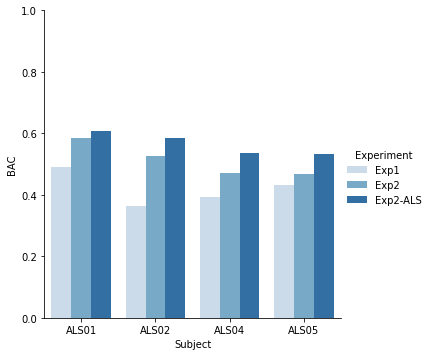

In [279]:
fig = sb.catplot(
    data=df[df["Task"] == "LRF0"], kind="bar",
    x="Subject", y="BAC", hue="Experiment",
    ci=None,
    palette="Blues"
).set(ylim=(0, 1))

In [280]:
fig.savefig("vinif_eeget_lrf0_exp1-2.png")

In [108]:
scorepatt = re.compile("\d+\.\d+")
subpatt = re.compile("ALS\d{2}_t\d{1,2}")

res = list()
with open("../vin/EEG_results/EEG_ALS_EA_LRF0.txt", mode="r", encoding="utf-8") as f:
    for line in f:
        line = line.strip()
        if line.startswith("subject ALS"):
            subject = subpatt.search(line).group()
            scores = [float(x) for x in scorepatt.findall(line)]
            res.append((subject, *scores))
            
res = pd.DataFrame(res, columns=["session", "bac", "f1", "kappa"])
res["subject"] = res["session"].apply(lambda x: x.split("_")[0])
res

,session,bac,f1,kappa,subject
0,ALS01_t1,0.557171,0.670858,0.530730,ALS01
1,ALS01_t10,0.712684,0.662327,0.493878,ALS01
2,ALS01_t2,0.542392,0.556458,0.359457,ALS01
3,ALS01_t3,0.558179,0.634548,0.500546,ALS01
4,ALS01_t4,0.511324,0.530547,0.361863,ALS01
5,ALS01_t5,0.588573,0.624202,0.497052,ALS01
6,ALS01_t6,0.686979,0.718733,0.613005,ALS01
7,ALS01_t7,0.594538,0.576577,0.446018,ALS01
8,ALS01_t8,0.669783,0.695854,0.582700,ALS01
9,ALS01_t9,0.645872,0.669027,0.560663,ALS01


In [109]:
res.groupby("subject").mean()

,bac,f1,kappa
subject,,,
ALS01,0.606749,0.633913,0.494591
ALS02,0.584876,0.578009,0.436597
ALS04,0.537001,0.542415,0.394695
ALS05,0.531646,0.585570,0.397722


In [110]:
res.mean()

/home/txdat/.miniconda3/envs/eeg/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


bac      0.570651
f1       0.587411
kappa    0.436934
dtype: float64

In [ ]:
# bac      0.722862
# f1       0.708683
# kappa    0.559613